# Step 2: Add SageMaker processing and training jobs
In this step you move data processing and model training into [SageMaker Docker containers](https://docs.aws.amazon.com/sagemaker/latest/dg/docker-containers.html) and use [SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/index.html) to interact with SageMaker.

![](img/six-steps-2.png)

SageMaker makes use of Docker containers to enable developers to process data, train and deploy models. Containers allow developers and data scientists to package software into standardized units that run consistently on any platform that supports Docker. Containers ensure that code, runtime, system tools, system libraries, and settings are all in the same place, isolating them from the execution environment. It guarantees a consistent runtime experience regardless of where a container is being run.

SageMaker also provides pre-build containers with popular data processing frameworks and ML algorithms. All SageMaker built-in algorithms are delivered as Docker containers.

<div class="alert alert-info"> Make sure you using <code>Data Science 3.0</code> image in Studio for this notebook.</div>

In [2]:
import time
import boto3
import botocore
import numpy as np  
import pandas as pd  
import sagemaker
import os
from time import gmtime, strftime, sleep
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sklearn.metrics import roc_auc_score
from sagemaker.experiments.run import Run, load_run

sagemaker.__version__

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


'2.210.0'

In [3]:
%store -r 

%store

try:
    initialized
except NameError:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN 00-start-here notebook   ")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")

Stored variables and their in-db values:
bucket_name                         -> 'sagemaker-us-east-1-598716374401'
bucket_prefix                       -> 'from-idea-to-prod/xgboost'
dataset_file_local_path             -> 'data/bank-additional/bank-additional-full.csv'
domain_id                           -> 'd-taruao9by6dl'
experiment_name                     -> 'from-idea-to-prod-experiment-06-18-08-59'
initialized                         -> True
input_s3_url                        -> 's3://sagemaker-us-east-1-598716374401/from-idea-t
region                              -> 'us-east-1'
sm_role                             -> 'arn:aws:iam::598716374401:role/service-role/Amazo
target_col                          -> 'y'


In [4]:
session = sagemaker.Session()
sm = session.sagemaker_client

## Load or create an experiment
Load the existing experiment we created in the previous notebook. You're going to track new runs in the same experiment.
You can also create a new experiment to track runs in this notebook.

In [ ]:
# Uncomment code block (Cmd + /) if you would like to create a new experiment
# experiment_name = f"from-idea-to-prod-experiment-{strftime('%d-%H-%M-%S', gmtime())}"

## Process data in SageMaker processing job
Use [SageMaker Processing](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job.html) by simply providing a Python data preprocessing script and choosing a [SageMaker SDK processor](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_processing.html) class.
You must upload the input data to S3 and specify an S3 location for output data. SageMaker Processing automatically loads the input data from S3 and uploads transformed data back to S3 when the job is complete. The processing container image can either be an Amazon SageMaker built-in image or a custom image that you provide. The underlying infrastructure for a Processing job is fully managed by Amazon SageMaker. Cluster resources are provisioned for the duration of your job, and cleaned up when a job completes.

![](img/sagemaker-processing.png)

Your input data must be stored in an Amazon S3 bucket. Alternatively, you can use [Amazon Athena](https://sagemaker.readthedocs.io/en/stable/api/utility/inputs.html#sagemaker.dataset_definition.inputs.AthenaDatasetDefinition) or [Amazon Redshift](https://sagemaker.readthedocs.io/en/stable/api/utility/inputs.html#sagemaker.dataset_definition.inputs.AthenaDatasetDefinition) as input sources.

Upload the input dataset to an Amazon S3 bucket:

In [5]:
input_s3_url = session.upload_data(
    path="data/bank-additional/bank-additional-full.csv",
    bucket=bucket_name,
    key_prefix=f"{bucket_prefix}/input"
)

%store input_s3_url

Stored 'input_s3_url' (str)


In [6]:
!aws s3 ls {bucket_name}/{bucket_prefix} --recursive

2024-03-06 20:55:21    5834924 from-idea-to-prod/xgboost/input/bank-additional-full.csv


Create a Python script by moving the data processing code from the step 1 notebook to a .py file:

In [7]:
%%writefile preprocessing.py

import pandas as pd
import numpy as np
import argparse
import os

def _parse_args():
    
    parser = argparse.ArgumentParser()
    # Data, model, and output directories
    # model_dir is always passed in from SageMaker. By default this is a S3 path under the default bucket.
    parser.add_argument('--filepath', type=str, default='/opt/ml/processing/input/')
    parser.add_argument('--filename', type=str, default='bank-additional-full.csv')
    parser.add_argument('--outputpath', type=str, default='/opt/ml/processing/output/')
    
    return parser.parse_known_args()


if __name__=="__main__":
    # Process arguments
    args, _ = _parse_args()
    
    target_col = "y"
    
    # Load data
    df_data = pd.read_csv(os.path.join(args.filepath, args.filename), sep=";")

    # Indicator variable to capture when pdays takes a value of 999
    df_data["no_previous_contact"] = np.where(df_data["pdays"] == 999, 1, 0)

    # Indicator for individuals not actively employed
    df_data["not_working"] = np.where(
        np.in1d(df_data["job"], ["student", "retired", "unemployed"]), 1, 0
    )

    # remove unnecessary data
    df_model_data = df_data.drop(
        ["duration", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"],
        axis=1,
    )

    df_model_data = pd.get_dummies(df_model_data)  # Convert categorical variables to sets of indicators

    # Replace "y_no" and "y_yes" with a single label column, and bring it to the front:
    df_model_data = pd.concat(
        [
            df_model_data["y_yes"].rename(target_col),
            df_model_data.drop(["y_no", "y_yes"], axis=1),
        ],
        axis=1,
    )

    # Shuffle and splitting dataset
    train_data, validation_data, test_data = np.split(
        df_model_data.sample(frac=1, random_state=1729),
        [int(0.7 * len(df_model_data)), int(0.9 * len(df_model_data))],
    )

    print(f"Data split > train:{train_data.shape} | validation:{validation_data.shape} | test:{test_data.shape}")
    
    # Save datasets locally
    train_data.to_csv(os.path.join(args.outputpath, 'train/train.csv'), index=False, header=False)
    validation_data.to_csv(os.path.join(args.outputpath, 'validation/validation.csv'), index=False, header=False)
    test_data[target_col].to_csv(os.path.join(args.outputpath, 'test/test_y.csv'), index=False, header=False)
    test_data.drop([target_col], axis=1).to_csv(os.path.join(args.outputpath, 'test/test_x.csv'), index=False, header=False)
    
    # Save the baseline dataset for model monitoring
    df_model_data.drop([target_col], axis=1).to_csv(os.path.join(args.outputpath, 'baseline/baseline.csv'), index=False, header=False)
    
    print("## Processing complete. Exiting.")

Writing preprocessing.py


The processing script contains a statement to save the whole dataset without the header and the label column as a baseline dataset. You need the data baseline later on in the model monitoring notebook.

Set the Amazon S3 paths:

In [8]:
train_s3_url = f"s3://{bucket_name}/{bucket_prefix}/train"
validation_s3_url = f"s3://{bucket_name}/{bucket_prefix}/validation"
test_s3_url = f"s3://{bucket_name}/{bucket_prefix}/test"
baseline_s3_url = f"s3://{bucket_name}/{bucket_prefix}/baseline"

In [9]:
%store train_s3_url
%store validation_s3_url
%store test_s3_url
%store baseline_s3_url

Stored 'train_s3_url' (str)
Stored 'validation_s3_url' (str)
Stored 'test_s3_url' (str)
Stored 'baseline_s3_url' (str)


Set the framework version and type and number of compute instances:

In [10]:
skprocessor_framework_version = "0.23-1"
processing_instance_type = "ml.m5.large"
processing_instance_count = 1

### Create a experiment run
Create a new run in your experiment to track parameters, configuration, inputs, and outputs of the processing job.

In [11]:
run_suffix = strftime('%Y-%m-%M-%S', gmtime())
run_name = f"container-processing-{run_suffix}"

with Run(
    experiment_name=experiment_name,
    run_name=run_name,
    run_display_name="container-processing",
    sagemaker_session=session
) as run:
    run.log_parameters(
        {
            "train": 0.7,
            "validate": 0.2,
            "test": 0.1
        }
    )
   
    experiment_config = run.experiment_config
    # time.sleep(8) # wait until resource tags are propagated to the run

### Create a processor
Instantiate a [`SKLearnProcessor`](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/sagemaker.sklearn.html#scikit-learn-processor) object before starting the SageMaker processing job. You specify the instance type to use in the job, as well as how many instances for distributed processing.

Note how SageMaker maps your data to the local paths on the processing container's EBS volume:

![](img/data-processing.png)

### Create a processor and set inputs and outputs
Instantiate a [`SKLearnProcessor`](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/sagemaker.sklearn.html#scikit-learn-processor) object before starting the SageMaker processing job. You specify the instance type to use in the job, as well as how many instances for distributed processing.

Note how SageMaker maps your data to the local paths on the processing container's EBS volume:

![](img/data-processing.png)

In [12]:
sklearn_processor = SKLearnProcessor(
    framework_version=skprocessor_framework_version,
    role=sm_role,
    instance_type=processing_instance_type,
    instance_count=processing_instance_count, 
    base_job_name='from-idea-to-prod-processing',
    sagemaker_session=session,
)

processing_inputs = [
        ProcessingInput(
            source=input_s3_url, 
            destination="/opt/ml/processing/input",
            s3_input_mode="File",
            s3_data_distribution_type="ShardedByS3Key"
        )
    ]

processing_outputs = [
        ProcessingOutput(
            output_name="train_data", 
            source="/opt/ml/processing/output/train",
            destination=train_s3_url,
        ),
        ProcessingOutput(
            output_name="validation_data", 
            source="/opt/ml/processing/output/validation", 
            destination=validation_s3_url
        ),
        ProcessingOutput(
            output_name="test_data", 
            source="/opt/ml/processing/output/test", 
            destination=test_s3_url
        ),
        ProcessingOutput(
            output_name="baseline_data", 
            source="/opt/ml/processing/output/baseline", 
            destination=baseline_s3_url
        ),
    ]

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


#### Start the SageMaker processing job



In [13]:
try:
    sklearn_processor.run(
        inputs=processing_inputs,
        outputs=processing_outputs,
        code='preprocessing.py',
        wait=True,
        experiment_config=experiment_config,
        # arguments = ['arg1', 'arg2'],
    )
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == 'AccessDeniedException':
        print(f"Ignore AccessDeniedException: {e.response['Error']['Message']} because of the slow resource tag auto propagation")
    else:
        raise e

INFO:sagemaker:Creating processing-job with name from-idea-to-prod-processing-2024-03-06-21-23-34-335


..........................Data split > train:(28831, 60) | validation:(8238, 60) | test:(4119, 60)
## Processing complete. Exiting.



In [ ]:
# If you set wait to False in the previous code cell, wait until the job completes
while sm.describe_processing_job(
        ProcessingJobName=sklearn_processor._current_job_name
    )["ProcessingJobStatus"] != "Completed":
    time.sleep(10)
    print(f"Wait until {sklearn_processor._current_job_name} completed")

To wait for job completion you can also use `boto3` [waiters](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html#waiters). For example:

```python
waiter = session.sagemaker_client.get_waiter('processing_job_completed_or_stopped')
waiter.wait(ProcessingJobName=sklearn_processor._current_job_name)
```

In [14]:
# list the uploaded files
!aws s3 ls {bucket_name}/{bucket_prefix} --recursive

2024-03-06 21:28:01    4982068 from-idea-to-prod/xgboost/baseline/baseline.csv
2024-03-06 20:55:21    5834924 from-idea-to-prod/xgboost/input/bank-additional-full.csv
2024-03-06 21:28:01     498254 from-idea-to-prod/xgboost/test/test_x.csv
2024-03-06 21:28:01       8238 from-idea-to-prod/xgboost/test/test_y.csv
2024-03-06 21:28:01    3544984 from-idea-to-prod/xgboost/train/train.csv
2024-03-06 21:28:01    1012968 from-idea-to-prod/xgboost/validation/validation.csv


## Run your local code remotely as a SageMaker job
You an use [SageMaker Python SDK decorator `@remote`](https://sagemaker.readthedocs.io/en/stable/remote_function/sagemaker.remote_function.html) to run you local code in the notebook as a SageMaker processing job – called the "Remote Function". This is an even easier way to run your Python code at scale using SageMaker distributed processing and training.

Refer to the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/train-remote-decorator.html) in the Amazon SageMaker developer guide.

In the following section you run the data processing code as a SageMaker job using `@remote` decorator.

### Step 1: Develop and test you code locally
First, you implement and test your code locally in the notebook to verify the correctness of code and environment.

In [15]:
# Load the dataset in to DataFrame
file_name = "bank-additional-full.csv"
input_path = "./data/bank-additional" 
df_data = pd.read_csv(os.path.join(input_path, file_name), sep=";")

In [17]:
# define a local function
def preprocess(
    df_data
):
    target_col = "y"
    
    # Indicator variable to capture when pdays takes a value of 999
    df_data["no_previous_contact"] = np.where(df_data["pdays"] == 999, 1, 0)

    # Indicator for individuals not actively employed
    df_data["not_working"] = np.where(
        np.in1d(df_data["job"], ["student", "retired", "unemployed"]), 1, 0
    )

    # remove unnecessary data
    df_model_data = df_data.drop(
        ["duration", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"],
        axis=1,
    )

    df_model_data = pd.get_dummies(df_model_data)  # Convert categorical variables to sets of indicators

    # Replace "y_no" and "y_yes" with a single label column, and bring it to the front:
    df_model_data = pd.concat(
        [
            df_model_data["y_yes"].rename(target_col),
            df_model_data.drop(["y_no", "y_yes"], axis=1),
        ],
        axis=1,
    )

    # Shuffle and splitting dataset
    train_data, validation_data, test_data = np.split(
        df_model_data.sample(frac=1, random_state=1729),
        [int(0.7 * len(df_model_data)), int(0.9 * len(df_model_data))],
    )

    print(f"Data split > train:{train_data.shape} | validation:{validation_data.shape} | test:{test_data.shape}")
    
    baseline_data = df_model_data.drop([target_col], axis=1)
    
    print("## Processing complete. Exiting.")
        
    return train_data, validation_data, test_data, baseline_data

In [18]:
# Call the function locally
train_data, validation_data, test_data, baseline_data = preprocess(df_data)

Data split > train:(28831, 60) | validation:(8238, 60) | test:(4119, 60)
## Processing complete. Exiting.


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [19]:
# see the processed data
train_data.head()

,y,age,campaign,pdays,previous,no_previous_contact,not_working,job_admin.,job_blue-collar,job_entrepreneur,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
40949,False,54,3,999,0,1,0,False,False,False,...,True,False,False,False,True,False,False,False,True,False
9332,False,56,2,999,0,1,0,False,True,False,...,False,False,True,False,False,False,False,False,True,False
32286,False,32,2,999,0,1,0,False,True,False,...,False,False,True,False,False,False,False,False,True,False
3925,False,46,3,999,0,1,0,True,False,False,...,False,False,False,True,False,False,False,False,True,False
9406,False,35,2,999,0,1,0,False,False,False,...,False,False,True,False,False,False,False,False,True,False


### Step 2: Execute the function remotely using RemoteExecutor
You can use [`RemoteExecutor`](https://sagemaker.readthedocs.io/en/stable/remote_function/sagemaker.remote_function.html#remoteexecutor) SageMaker Python SDK class to run the local function remotely as a SageMaker job. You can run multiple jobs in paralle using `max_parallel_jobs` parameter to control the max number of parallel jobs.

In [20]:
from sagemaker.remote_function import remote, RemoteExecutor

In [21]:
s3_root_uri = f"s3://{bucket_name}/{bucket_prefix}"

In [22]:
with RemoteExecutor(s3_root_uri=s3_root_uri, instance_type=processing_instance_type) as e:
    future = e.submit(preprocess, df_data)                 

2024-03-06 21:32:35,463 sagemaker.remote_function INFO     Serializing function code to s3://sagemaker-us-east-1-598716374401/from-idea-to-prod/xgboost/preprocess-2024-03-06-21-32-35-463/function
2024-03-06 21:32:35,653 sagemaker.remote_function INFO     Serializing function arguments to s3://sagemaker-us-east-1-598716374401/from-idea-to-prod/xgboost/preprocess-2024-03-06-21-32-35-463/arguments
2024-03-06 21:32:36,162 sagemaker.remote_function INFO     Creating job: preprocess-2024-03-06-21-32-35-463


In [23]:
train_data, validation_data, test_data, baseline_data = future.result()

2024-03-06 21:35:26 Starting - Preparing the instances for training
2024-03-06 21:35:26 Downloading - Downloading the training image
2024-03-06 21:35:26 Training - Training image download completed. Training in progress.
2024-03-06 21:35:26 Uploading - Uploading generated training model
2024-03-06 21:35:26 Completed - Training job completedINFO: CONDA_PKGS_DIRS is set to '/opt/ml/sagemaker/warmpoolcache/sm_remotefunction_user_dependencies_cache/conda/pkgs'
INFO: PIP_CACHE_DIR is set to '/opt/ml/sagemaker/warmpoolcache/sm_remotefunction_user_dependencies_cache/pip'
INFO: Bootstraping runtime environment.
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
/opt/conda/bin/conda
2024-03-06 21:35:07,786 sagemaker.remote_function WARNING  Inconsistent sagemaker versions found: sagemaker pysdk version found in the container is '2.199.0' which does no

In [25]:
# see the processed data
train_data.head()

,y,age,campaign,pdays,previous,no_previous_contact,not_working,job_admin.,job_blue-collar,job_entrepreneur,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
40949,False,54,3,999,0,1,0,False,False,False,...,True,False,False,False,True,False,False,False,True,False
9332,False,56,2,999,0,1,0,False,True,False,...,False,False,True,False,False,False,False,False,True,False
32286,False,32,2,999,0,1,0,False,True,False,...,False,False,True,False,False,False,False,False,True,False
3925,False,46,3,999,0,1,0,True,False,False,...,False,False,False,True,False,False,False,False,True,False
9406,False,35,2,999,0,1,0,False,False,False,...,False,False,True,False,False,False,False,False,True,False


### Step 3: Run code with @remote decorator
Now you can apply `@remote` to the function once the local and remote test runs successfully. 
You can also set default settings for remote functions via a [configuration file](https://docs.aws.amazon.com/sagemaker/latest/dg/train-remote-decorator-config.html). The configuration file is used when invoking a function with `@remote` decorator or `RemoteExecutor` API.

In [26]:
@remote(s3_root_uri=s3_root_uri, instance_type=processing_instance_type)
def preprocess(
    df_data
):
    target_col = "y"
    
    # Indicator variable to capture when pdays takes a value of 999
    df_data["no_previous_contact"] = np.where(df_data["pdays"] == 999, 1, 0)

    # Indicator for individuals not actively employed
    df_data["not_working"] = np.where(
        np.in1d(df_data["job"], ["student", "retired", "unemployed"]), 1, 0
    )

    # remove unnecessary data
    df_model_data = df_data.drop(
        ["duration", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"],
        axis=1,
    )

    df_model_data = pd.get_dummies(df_model_data)  # Convert categorical variables to sets of indicators

    # Replace "y_no" and "y_yes" with a single label column, and bring it to the front:
    df_model_data = pd.concat(
        [
            df_model_data["y_yes"].rename(target_col),
            df_model_data.drop(["y_no", "y_yes"], axis=1),
        ],
        axis=1,
    )

    # Shuffle and splitting dataset
    train_data, validation_data, test_data = np.split(
        df_model_data.sample(frac=1, random_state=1729),
        [int(0.7 * len(df_model_data)), int(0.9 * len(df_model_data))],
    )

    print(f"Data split > train:{train_data.shape} | validation:{validation_data.shape} | test:{test_data.shape}")
    
    baseline_data = df_model_data.drop([target_col], axis=1)
    
    print("## Processing complete. Exiting.")
        
    return train_data, validation_data, test_data, baseline_data

In [27]:
run_suffix = strftime('%Y-%m-%M-%S', gmtime())
run_name = f"remote-function-processing-{run_suffix}"

# Create an experiment run and run the function remotely as a SageMaker job
with Run(
    experiment_name=experiment_name,
    run_name=run_name,
    run_display_name="remote-function-processing",
    sagemaker_session=session
) as run:
    train_data, validation_data, test_data, baseline_data = preprocess(df_data)

2024-03-06 21:37:23,809 sagemaker.remote_function INFO     Serializing function code to s3://sagemaker-us-east-1-598716374401/from-idea-to-prod/xgboost/preprocess-2024-03-06-21-37-23-809/function
2024-03-06 21:37:23,935 sagemaker.remote_function INFO     Serializing function arguments to s3://sagemaker-us-east-1-598716374401/from-idea-to-prod/xgboost/preprocess-2024-03-06-21-37-23-809/arguments
2024-03-06 21:37:24,344 sagemaker.remote_function INFO     Creating job: preprocess-2024-03-06-21-37-23-809


2024-03-06 21:37:24 Starting - Starting the training job...
2024-03-06 21:37:40 Starting - Preparing the instances for training...
2024-03-06 21:38:22 Downloading - Downloading input data...
2024-03-06 21:38:47 Downloading - Downloading the training image......
2024-03-06 21:39:53 Training - Training image download completed. Training in progress...INFO: CONDA_PKGS_DIRS is set to '/opt/ml/sagemaker/warmpoolcache/sm_remotefunction_user_dependencies_cache/conda/pkgs'
INFO: PIP_CACHE_DIR is set to '/opt/ml/sagemaker/warmpoolcache/sm_remotefunction_user_dependencies_cache/pip'
INFO: Bootstraping runtime environment.
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
/opt/conda/bin/conda
2024-03-06 21:39:59,404 sagemaker.remote_function WARNING  Inconsistent sagemaker versions found: sagemaker pysdk version found in the container is '2.199.0' whic

In [28]:
# see the processed data
train_data.head()

,y,age,campaign,pdays,previous,no_previous_contact,not_working,job_admin.,job_blue-collar,job_entrepreneur,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
40949,False,54,3,999,0,1,0,False,False,False,...,True,False,False,False,True,False,False,False,True,False
9332,False,56,2,999,0,1,0,False,True,False,...,False,False,True,False,False,False,False,False,True,False
32286,False,32,2,999,0,1,0,False,True,False,...,False,False,True,False,False,False,False,False,True,False
3925,False,46,3,999,0,1,0,True,False,False,...,False,False,False,True,False,False,False,False,True,False
9406,False,35,2,999,0,1,0,False,False,False,...,False,False,True,False,False,False,False,False,True,False


For more examples of remote functions see SageMaker [example notebooks](https://docs.aws.amazon.com/sagemaker/latest/dg/train-remote-decorator-examples.html).

## Model training in SageMaker training job
Follow the same approach and now run the model training as a [SageMaker training job](https://sagemaker.readthedocs.io/en/stable/overview.html#using-estimators).

In [29]:
# get training container uri
training_image = sagemaker.image_uris.retrieve("xgboost", region=region, version="1.5-1")

print(training_image)

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.5-1


Define the data input channels for the training job. Set _train_ and _validation_ channels via the SageMaker SDK [`TrainingInput`](https://sagemaker.readthedocs.io/en/stable/api/utility/inputs.html#sagemaker.inputs.TrainingInput) class:

In [30]:
s3_input_train = sagemaker.inputs.TrainingInput(train_s3_url, content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(validation_s3_url, content_type='csv')

In [31]:
train_instance_count = 1
train_instance_type = "ml.m5.xlarge"

# Define where the training job stores the model artifact
output_s3_url = f"s3://{bucket_name}/{bucket_prefix}/output"

%store output_s3_url

Stored 'output_s3_url' (str)


Instantiate an [Estimator](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) object and set algorithm's hyperparameters. Refer to [XGBoost hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html) for more information.

In [32]:
# Instantiate an XGBoost estimator object
estimator = sagemaker.estimator.Estimator(
    image_uri=training_image,  # XGBoost algorithm container
    instance_type=train_instance_type,  # type of training instance
    instance_count=train_instance_count,  # number of instances to be used
    role=sm_role,  # IAM execution role to be used
    max_run=20 * 60,  # Maximum allowed active runtime
    # use_spot_instances=True,  # Use spot instances to reduce cost
    # max_wait=30 * 60,  # Maximum clock time (including spot delays)
    output_path=output_s3_url, # S3 location for saving the training result
    sagemaker_session=session, # Session object which manages interactions with SageMaker API and AWS services
    base_job_name="from-idea-to-prod-training", # Prefix for training job name
)

# define its hyperparameters
estimator.set_hyperparameters(
    num_round=150, # the number of rounds to run the training
    max_depth=3, # maximum depth of a tree
    eta=0.5, # step size shrinkage used in updates to prevent overfitting
    alpha=2.5, # L1 regularization term on weights
    objective="binary:logistic",
    eval_metric="auc", # evaluation metrics for validation data
    subsample=0.8, # subsample ratio of the training instance
    colsample_bytree=0.8, # subsample ratio of columns when constructing each tree
    min_child_weight=3, # minimum sum of instance weight (hessian) needed in a child
    early_stopping_rounds=10, # the model trains until the validation score stops improving
    verbosity=1, # verbosity of printing messages
)

Run the training:

In [33]:
training_inputs = {'train': s3_input_train, 'validation': s3_input_validation}

In [34]:
try:
    run_suffix = strftime('%Y-%m-%M-%S', gmtime())
    run_name = f"container-training-{run_suffix}"

    with Run(experiment_name=experiment_name,
             run_name=run_name,
             run_display_name="container-training",
             sagemaker_session=session
            ) as run:
        
        estimator.fit(
            training_inputs,
            wait=True,
            logs=False,
        ) 
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == 'AccessDeniedException':
        print(f"Ignore AccessDeniedException: {e.response['Error']['Message']} because of the slow resource tag auto propagation")
    else:
        raise e

INFO:sagemaker:Creating training-job with name: from-idea-to-prod-training-2024-03-06-21-49-56-700



2024-03-06 21:50:01 Starting - Starting the training job..
2024-03-06 21:50:16 Starting - Preparing the instances for training.....
2024-03-06 21:50:47 Downloading - Downloading input data....
2024-03-06 21:51:12 Downloading - Downloading the training image......
2024-03-06 21:51:47 Training - Training image download completed. Training in progress....
2024-03-06 21:52:03 Uploading - Uploading generated training model.
2024-03-06 21:52:14 Completed - Training job completed


### Reduce training job startup time with warm pools
💡 Instead of using each time a new ephemeral computation cluster to train your models, you can keep your model training hardware instances warm after every job for a specified period. Refer to [Reduce ML Model Training Job startup time by up to 8x using SageMaker Training Managed Warm Pools](https://aws.amazon.com/about-aws/whats-new/2022/09/reduce-ml-model-training-job-startup-time-8x-sagemaker-training-managed-warm-pools/) for more details. If you opt to use warm pools, you are billed for the instances and EBS volumes for the duration of the keep-alive period. 
Refer to [ Train Using SageMaker Managed Warm Pools](https://docs.aws.amazon.com/sagemaker/latest/dg/train-warm-pools.html) in the Amazon SageMaker Developer Guide for details on training API.

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <p style=" text-align: center; margin: auto;">To use warm pool feature you must have a corresponding warm pool quota for a required instance type set to value greater than 0.
    <br>
    <br>
    Do not run this section in AWS provisioned workshop account as the warm pool quota is set to 0.
    </p>
</div>

#### Optional: Train with SageMaker warm pools
Let's use this feature and run XGBoost training using warm pools.
Notice the matching attributes of a training job to re-use the provisioned infrastructure from a previous job: [Matching criteria](https://docs.aws.amazon.com/sagemaker/latest/dg/train-warm-pools.html#train-warm-pools-matching-criteria)

To create a warm pool you need to set `KeepAlivePeriodInSeconds` parameter in `Estimator` configuration to value greater than 0.

In [ ]:
# Instantiate an XGBoost estimator object
warm_pool_estimator = sagemaker.estimator.Estimator(
    image_uri=training_image,  # XGBoost algorithm container
    instance_type=train_instance_type,  # type of training instance
    instance_count=train_instance_count,  # number of instances to be used
    role=sm_role,  # IAM execution role to be used
    max_run=20 * 60,  # Maximum allowed active runtime
    # use_spot_instances=True,  # Use spot instances to reduce cost
    # max_wait=30 * 60,  # Maximum clock time (including spot delays)
    output_path=output_s3_url, # S3 location for saving the training result
    sagemaker_session=session, # Session object which manages interactions with SageMaker API and AWS services
    base_job_name="from-idea-to-prod-training", # Prefix for training job name
    keep_alive_period_in_seconds=1800, # use the warm pool feature
)

In [ ]:
training_inputs = {'train': s3_input_train, 'validation': s3_input_validation}

Run a training job by calling `estimator.fit()` several consequent times with different hyperparameters. The initial training job "cold-starts" as SageMaker provisions required compute infrastructure for it. When this job completes, the infrastructure kept alive for the period `KeepAlivePeriodInSeconds`. The warm pool stays `Available` until it either identifies a matching training job for reuse or it exceeds the specified `KeepAlivePeriodInSeconds` and is terminated.

In [ ]:
# run the training job five times
for i, d in enumerate([2, 3, 5, 10, 20]):
    print(f"Fit estimator with max_depth={d}")

    warm_pool_estimator.set_hyperparameters(
        num_round=50, # the number of rounds to run the training
        max_depth=d, # maximum depth of a tree
        objective="binary:logistic",
        eval_metric="auc", # evaluation metrics for validation data
        early_stopping_rounds=10, # the model trains until the validation score stops improving
    )
    warm_pool_estimator.fit(
        training_inputs,
        wait=True,
        logs=False,
    )

### Output model performance

In [35]:
if estimator._current_job_name:
    training_job_name = estimator._current_job_name

In [42]:
print(run_name)
print(training_job_name)

container-training-2024-03-49-55
from-idea-to-prod-training-2024-03-06-21-49-56-700


In [44]:
metrics = None
while not metrics:
    metrics = sm.describe_training_job(
        TrainingJobName=training_job_name
        ).get("FinalMetricDataList")

    if not metrics:
        print(f"Training job {training_job_name} hasn't finished yet!")
        time.sleep(10)
    
train_auc = float([m['Value'] for m in metrics if m['MetricName'] == 'train:auc'][0])
validate_auc = float([m['Value'] for m in metrics if m['MetricName'] == 'validation:auc'][0])

print(f"Train-auc:{train_auc:.3f}, Validate-auc:{validate_auc:.3f}")

Train-auc:0.787, Validate-auc:0.767


In [43]:
metrics

[{'MetricName': 'validation:auc',
  'Value': 0.7668099999427795,
  'Timestamp': datetime.datetime(2024, 3, 6, 21, 51, 59, tzinfo=tzlocal())},
 {'MetricName': 'train:auc',
  'Value': 0.7865800261497498,
  'Timestamp': datetime.datetime(2024, 3, 6, 21, 51, 59, tzinfo=tzlocal())}]

In [38]:
%store training_job_name

Stored 'training_job_name' (str)


In [39]:
# Print the S3 path to the model artifact:
estimator.model_data

's3://sagemaker-us-east-1-598716374401/from-idea-to-prod/xgboost/output/from-idea-to-prod-training-2024-03-06-21-49-56-700/output/model.tar.gz'

## Validate model
The training job saved a model in the specified location on Amazon S3.

You can deploy the model as a [real-time endpoint](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints.html), which is just one [function call](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html#sagemaker.estimator.Estimator.deploy), or create a [batch transform](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html) to predict a label for a large dataset.

### Real-time inference
To test [real-time inference](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints.html) you create a real-time endpoint using the trained estimator.

In [45]:
# Real-time endpoint
endpoint_name = f"from-idea-to-prod-endpoint-{strftime('%d-%H-%M-%S', gmtime())}"

try:
    predictor = estimator.deploy(
        initial_instance_count=1,
        instance_type="ml.m5.large",
        wait=False,  # Remember, predictor.predict() won't work until deployment finishes!
        # Turn on data capture here, in case you want to experiment with monitoring:
        data_capture_config=sagemaker.model_monitor.DataCaptureConfig(
            enable_capture=True,
            sampling_percentage=100,
            destination_s3_uri=f"s3://{bucket_name}/{bucket_prefix}/data-capture",
        ),
        endpoint_name=endpoint_name,
        serializer=sagemaker.serializers.CSVSerializer(),
        deserializer=sagemaker.deserializers.CSVDeserializer(),
    )
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == 'AccessDeniedException':
        print(f"Ignore AccessDeniedException: {e.response['Error']['Message']} because of the slow resource tag auto propagation")
        predictor = sagemaker.predictor.Predictor(endpoint_name=endpoint_name,
                                                  sagemaker_session=session,
                                                  serializer=sagemaker.serializers.CSVSerializer(),
                                                  deserializer=sagemaker.deserializers.CSVDeserializer(),
                                                 )
    else:
        raise e

INFO:sagemaker:Creating model with name: from-idea-to-prod-training-2024-03-06-22-55-21-019
INFO:sagemaker:Creating endpoint-config with name from-idea-to-prod-endpoint-06-22-55-20
INFO:sagemaker:Creating endpoint with name from-idea-to-prod-endpoint-06-22-55-20


In [46]:
# Wait until the endpoint has the status InService
waiter = session.sagemaker_client.get_waiter('endpoint_in_service')
waiter.wait(EndpointName=endpoint_name)

#### Predict

In [47]:
!aws s3 cp $test_s3_url/test_x.csv tmp/test_x.csv
!aws s3 cp $test_s3_url/test_y.csv tmp/test_y.csv

download: s3://sagemaker-us-east-1-598716374401/from-idea-to-prod/xgboost/test/test_x.csv to tmp/test_x.csv
download: s3://sagemaker-us-east-1-598716374401/from-idea-to-prod/xgboost/test/test_y.csv to tmp/test_y.csv


In [48]:
test_x = pd.read_csv("tmp/test_x.csv", names=[f'{i}' for i in range(59)])
test_y = pd.read_csv("tmp/test_y.csv", names=['y'])

In [49]:
predictions = np.array(predictor.predict(test_x.values), dtype=float).squeeze()
predictions

array([0.06094802, 0.09423219, 0.20767137, ..., 0.04564261, 0.03911222,
       0.03352626])

#### Evaluate predictions

In [50]:
test_results = pd.concat(
    [
        pd.Series(predictions, name="y_pred", index=test_x.index),
        test_x,
    ],
    axis=1,
)
test_results.head()

,y_pred,0,1,2,3,4,5,6,7,8,...,49,50,51,52,53,54,55,56,57,58
0,0.060948,25,1,999,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0.094232,28,3,999,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,0.207671,38,1,999,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0.256129,32,1,999,1,1,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
4,0.039112,40,1,999,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [53]:
test_y.head()

,y
0,0
1,1
2,1
3,1
4,0


In [51]:
pd.crosstab(
    index=test_y['y'].values,
    columns=np.round(predictions), 
    rownames=['actuals'], 
    colnames=['predictions']
)

predictions,0.0,1.0
actuals,,
0,3602,34
1,401,82


In [66]:
test_auc = roc_auc_score(test_y, test_results["y_pred"])
print(f"Test-auc: {test_auc:.3f}")

Test-auc: 0.767


### Batch transform
If you want to run a prediction on a large dataset or don't need a real-time endpoint, you can use SageMaker [batch-transform](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html).

In [55]:
transform_s3_url = f"s3://{bucket_name}/{bucket_prefix}/transform"

<div class="alert alert-info"> 💡 To create a transformer, use either <b>option 1</b> or <b>option 2</b>
</div>

#### Option 1: create a batch transformer from the trained estimator
You can use [`EstimatorBase.transformer()`](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html#sagemaker.estimator.EstimatorBase.transformer) to create a transformer for an estimator:

In [56]:
model_name = f"from-idea-to-prod-transform-{strftime('%d-%H-%M-%S', gmtime())}"

transformer = estimator.transformer(
    instance_count=1,
    instance_type=train_instance_type,
    accept="text/csv",
    role=sm_role,
    output_path=transform_s3_url,
    model_name=model_name,
)

INFO:sagemaker:Creating model with name: from-idea-to-prod-transform-06-23-06-29


Go to the section **Run transform job**.

#### Option 2: load a model from a training job
Alternatively, you can load a model from a model artifact produced by a training job. You create a transformer with that model.

In [57]:
model = session.create_model_from_job(
    training_job_name=training_job_name, 
    name=model_name,
)

INFO:sagemaker:Creating model with name: from-idea-to-prod-transform-06-23-06-29


In [ ]:
transformer = sagemaker.transformer.Transformer(
    model_name=model,
    instance_count=1,
    instance_type=train_instance_type,
    accept="text/csv",
    assemble_with="Line",
    output_path=transform_s3_url,
    base_transform_job_name="from-idea-to-prod-trasform",
    sagemaker_session=session,
)

#### Run transform job



In [58]:
transform_job_name = f"from-idea-to-prod-transform-{strftime('%d-%H-%M-%S', gmtime())}"

try:
    run_suffix = strftime('%Y-%m-%M-%S', gmtime())
    run_name = f"batch-transform-{run_suffix}"

    with Run(experiment_name=experiment_name,
             run_name=run_name,
             run_display_name="batch-transform",
             sagemaker_session=session
            ) as run:
        transformer.transform(    
            data=f"{test_s3_url}/test_x.csv",
            content_type="text/csv",
            split_type="Line", 
            job_name=transform_job_name,
            wait=True,
            # experiment_config=experiment_config,
        )
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == 'AccessDeniedException':
        print(f"Ignore AccessDeniedException: {e.response['Error']['Message']} because of the slow resource tag auto propagation")
    else:
        raise e

INFO:sagemaker:Creating transform job with name: from-idea-to-prod-transform-06-23-09-07


................................/miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2024-03-06:23:14:25:INFO] No GPUs detected (normal if no gpus installed)
[2024-03-06:23:14:25:INFO] No GPUs detected (normal if no gpus installed)
[2024-03-06:23:14:25:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
/miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2024-03-06:23:14:25:INFO] No GPUs detected (normal if no gpus installed)
[2024-03-06:23:14:25:INFO] No GPUs detecte

In [59]:
while sm.describe_transform_job(
        TransformJobName=transformer._current_job_name
    )["TransformJobStatus"] != "Completed":
    time.sleep(10)
    print(f"Wait until {transformer._current_job_name} completed")

In [60]:
transformer.output_path

's3://sagemaker-us-east-1-598716374401/from-idea-to-prod/xgboost/transform'

#### Evaluate predictions

In [61]:
!aws s3 ls {transformer.output_path}/

2024-03-06 23:14:32      82337 test_x.csv.out


In [62]:
!aws s3 cp {transformer.output_path}/test_x.csv.out tmp/predictions.csv
!aws s3 cp $test_s3_url/test_y.csv tmp/test_y.csv

download: s3://sagemaker-us-east-1-598716374401/from-idea-to-prod/xgboost/transform/test_x.csv.out to tmp/predictions.csv
download: s3://sagemaker-us-east-1-598716374401/from-idea-to-prod/xgboost/test/test_y.csv to tmp/test_y.csv


In [63]:
predictions = pd.read_csv("tmp/predictions.csv", names=["y_prob"])
test_y = pd.read_csv("tmp/test_y.csv", names=['y'])

#### Crosstab

In [64]:
pd.crosstab(
    index=test_y['y'].values,
    columns=np.array(np.round(predictions), dtype=float).squeeze(), 
    rownames=['actuals'], 
    colnames=['predictions']
)

predictions,0.0,1.0
actuals,,
0,3602,34
1,401,82


In [67]:
test_auc = roc_auc_score(test_y, predictions)
print(f"Test-auc: {test_auc:.3f}")

Test-auc: 0.767


#### ROC curve

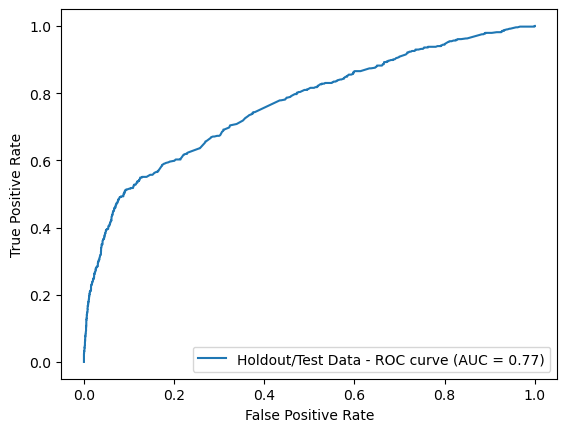

In [68]:
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt


fpr, tpr, thresholds = metrics.roc_curve(test_y, predictions)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='Holdout/Test Data - ROC curve')
display.plot()
plt.show()

In [74]:
# Calculate the distance to the top-left corner
distances = (fpr**2 + (1-tpr)**2)**0.5

# Find the optimal threshold.
optimal_idx = np.argmin(distances)
optimal_threshold = thresholds[optimal_idx]

print(len(thresholds))
print(f"The optimal index is {optimal_idx}")
print(f"The optimal threshold is {optimal_threshold}")

818
The optimal index is 394
The optimal threshold is 0.092008002102375


In [75]:
print(thresholds)

[       inf 0.9396596  0.83814329 0.83027166 0.8162598  0.81122887
 0.80736572 0.80632854 0.78449231 0.7840091  0.76987433 0.76589435
 0.76541746 0.76341438 0.75817662 0.75537241 0.75114805 0.73876184
 0.73745251 0.73004329 0.72623789 0.70839244 0.70837438 0.70124775
 0.6896013  0.6877346  0.68419176 0.6742906  0.66662055 0.66643149
 0.66051126 0.66040874 0.6351583  0.63296187 0.63112646 0.6284312
 0.60200316 0.60185969 0.60142225 0.5995028  0.59377134 0.59183055
 0.5780831  0.57163113 0.56760335 0.56697714 0.56445104 0.55971426
 0.55793244 0.55364549 0.55110854 0.53143829 0.52927917 0.50923491
 0.50791693 0.50651985 0.50280505 0.50248855 0.49979433 0.49889499
 0.4940587  0.49133363 0.49041125 0.48897195 0.48764387 0.48297521
 0.4812617  0.47898895 0.47782326 0.474309   0.4699851  0.46974435
 0.46533009 0.4585731  0.45724741 0.45412165 0.45388332 0.44393471
 0.44121945 0.43922624 0.43618569 0.4300814  0.42738554 0.42720625
 0.42592758 0.41788098 0.41561803 0.41416246 0.41330236 0.41095

#### Confusion matrix

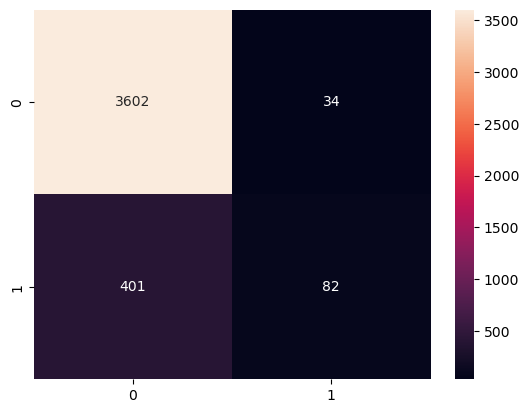

In [76]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(test_y, np.round(predictions))
f = sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [79]:
# new confusion matrix

# Assuming y_predictions is an array of predicted probabilities for the positive class
# and test_y is the true binary labels
optimal_threshold = 0.092008

# Convert probabilities to binary predictions using the new threshold
new_predictions = (predictions > optimal_threshold).astype(int)

# Calculate the confusion matrix
new_confusion_matrix = confusion_matrix(test_y, new_predictions)

print(new_confusion_matrix)

[[2611 1025]
 [ 160  323]]


#### Precision-recall curve

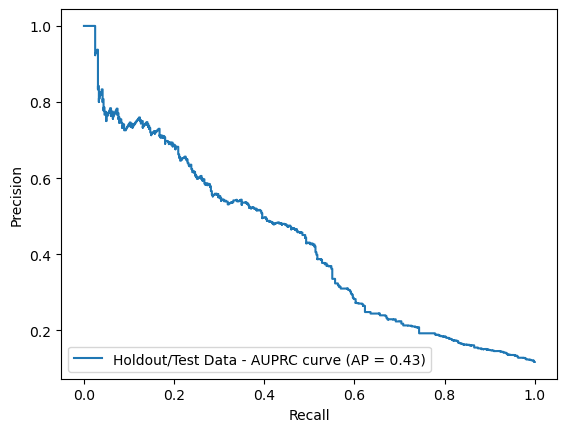

In [80]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

prec, recall, _ = precision_recall_curve(test_y, predictions)
average_precision= metrics.average_precision_score(test_y, predictions)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall, average_precision=average_precision, estimator_name='Holdout/Test Data - AUPRC curve')
pr_display.plot()
plt.show()

### Save charts to the experiment run
You can use the [`experiments.load_run()`](https://sagemaker.readthedocs.io/en/stable/experiments/sagemaker.experiments.html#sagemaker.experiments.load_run) method to load an existing run.

In [82]:
title_suffix = strftime('%Y-%m-%M-%S', gmtime())

with load_run(experiment_name=experiment_name, run_name=run_name) as run:
    print(run.experiment_config)
    run.log_confusion_matrix(y_true=test_y['y'].values,
                             y_pred=np.array(np.round(predictions), dtype=float).squeeze(), 
                             title=f"confusion-matrix-{title_suffix}")
    run.log_roc_curve(y_true=test_y['y'].values, 
                      y_score=predictions['y_prob'].values, 
                      title=f"roc-curve2-{title_suffix}")
    run.log_precision_recall(y_true=test_y['y'].values,
                             predicted_probabilities=predictions['y_prob'].values,
                             positive_label=1,
                             title=f"precision-recall-{title_suffix}")

INFO:sagemaker.experiments.run:The run (batch-transform-2024-03-09-07) under experiment (from-idea-to-prod-experiment-06-18-08-59) already exists. Loading it.


{'ExperimentName': 'from-idea-to-prod-experiment-06-18-08-59', 'TrialName': 'Default-Run-Group-from-idea-to-prod-experiment-06-18-08-59', 'RunName': 'from-idea-to-prod-experiment-06-18-08-59-batch-transform-2024-03-09-07'}


## Explore experiments and runs with Studio UX
You can see all logged metrics, parameters, and artifacts in Studio UX in **SageMaker Home** > **Experiments** widget.

For example, click on your experiment name you used in this notebook:

![](img/experiment-and-runs.png)

You see runs which you created in this notebook:

![](img/runs-02.png)

Select `batch-transform-<timestamp>` run and choose **Charts** in the **Overview** section on the left pane. You see the three added charts in the run:

![](img/run-charts.png)


---

## Optional: Hyperparameter optimization (HPO)
It takes about 20 minutes to run this section. The section is optional and you don't need to run it to continue with other notebooks. You can navigate directly to step 3 [notebook](03-sagemaker-pipeline.ipynb). If you would like to perform a model A/B test in **Additional topics** sections, you can execute this part to produce an alternative model.

[Amazon SageMaker automatic model tuning](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html), also called hyperparameter optimization (HPO), finds the best performing model against a defined objective metric by running many training jobs on the dataset using the algorithm and ranges of hyperparameters that you specify. SageMaker HPT supports random search, bayesian optimization, and [hyperband](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-how-it-works.html) as tuning strategies.

In [83]:
# import required HPO objects
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
    IntegerParameter,
)

In [84]:
# set up hyperparameter ranges
hp_ranges = {
    "min_child_weight": ContinuousParameter(1, 10),
    "max_depth": IntegerParameter(1, 10),
    "alpha": ContinuousParameter(0, 5),
    "eta": ContinuousParameter(0, 1),
    "colsample_bytree": ContinuousParameter(0, 1),
    "gamma": ContinuousParameter(0, 10)
    
}

# set up the objective metric
objective = "validation:auc"

# instantiate a HPO object
tuner = HyperparameterTuner(
    estimator=estimator,  # the SageMaker estimator object
    hyperparameter_ranges=hp_ranges,  # the range of hyperparameters
    max_jobs=30,  # total number of HPO jobs
    max_parallel_jobs=3,  # how many HPO jobs can run in parallel
    strategy="Bayesian",  # the internal optimization strategy of HPO
    objective_metric_name=objective,  # the objective metric to be used for HPO
    objective_type="Maximize",  # maximize or minimize the objective metric
    base_tuning_job_name="from-idea-to-prod-hpo",
    early_stopping_type="Auto",
)

Now run the HPO job. It takes about 10 minutes to complete. 

<div class="alert alert-info"> 💡 Note, that the HPO job creates its own experiment to track each training job with a specific set of hyperparameters as a separate run.
</div>

In [85]:
tuner.fit(
    {"train": s3_input_train, "validation": s3_input_validation},
)

INFO:sagemaker:Creating hyperparameter tuning job with name: from-idea-to-prod-hp-240307-0112


........................................................................................................................!


In [86]:
print(f"HPO job status: {sm.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']}")

HPO job status: Completed


In [87]:
hpo_predictor = tuner.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    serializer=sagemaker.serializers.CSVSerializer(),
    deserializer=sagemaker.deserializers.CSVDeserializer(),
)


2024-03-07 01:22:47 Starting - Found matching resource for reuse
2024-03-07 01:22:47 Downloading - Downloading the training image
2024-03-07 01:22:47 Training - Training image download completed. Training in progress.
2024-03-07 01:22:47 Uploading - Uploading generated training model
2024-03-07 01:22:47 Completed - Resource retained for reuse

INFO:sagemaker:Creating model with name: from-idea-to-prod-hp-2024-03-07-01-23-06-965


INFO:sagemaker:Creating endpoint-config with name from-idea-to-prod-hp-240307-0112-029-15b2e4d4
INFO:sagemaker:Creating endpoint with name from-idea-to-prod-hp-240307-0112-029-15b2e4d4


----!

In [88]:
hpo_predictions = np.array(hpo_predictor.predict(test_x.values), dtype=float).squeeze()
print(hpo_predictions)

[0.03988077 0.09935527 0.16872258 ... 0.03719131 0.03005487 0.05444549]


In [89]:
pd.crosstab(
    index=test_y['y'].values,
    columns=np.round(hpo_predictions), 
    rownames=['actuals'], 
    colnames=['predictions']
)

predictions,0.0,1.0
actuals,,
0,3584,52
1,382,101


There is only a small improvements for the model metrics. It can indicate, that the XGBoost model is already at it's limit. You might want to explore other model types to improve the prediction accuracy for this use case.

---

## Clean-up
To avoid charges, remove the hosted endpoint you created.

In [90]:
predictor.delete_endpoint(delete_endpoint_config=True)

INFO:sagemaker:Deleting endpoint configuration with name: from-idea-to-prod-endpoint-06-22-55-20
INFO:sagemaker:Deleting endpoint with name: from-idea-to-prod-endpoint-06-22-55-20


In [91]:
# run if you created a tuned predictor after HPO
hpo_predictor.delete_endpoint(delete_endpoint_config=True)

INFO:sagemaker:Deleting endpoint configuration with name: from-idea-to-prod-hp-240307-0112-029-15b2e4d4
INFO:sagemaker:Deleting endpoint with name: from-idea-to-prod-hp-240307-0112-029-15b2e4d4


## Continue with the step 3
open the step 3 [notebook](03-sagemaker-pipeline.ipynb).

## Further development ideas for your real-world projects
- Track, organize, and compare all your model training runs using [SageMaker Experiments](https://docs.aws.amazon.com/sagemaker/latest/dg/experiments.html)
- Use [Amazon SageMaker Data Wrangler](https://aws.amazon.com/sagemaker/data-wrangler/) for creating a no-code or low-code visual data processing and feature engineering flow. Refer to this hands-on tutorial: [Prepare Training Data for Machine Learning with Minimal Code](https://aws.amazon.com/getting-started/hands-on/machine-learning-tutorial-prepare-data-with-minimal-code/)
- Try no-code [SageMaker Canvas](https://docs.aws.amazon.com/sagemaker/latest/dg/canvas.html) on your data to perform analysis and use automated ML to build models and generate predictions

## Additional resources
- [Using Docker containers with SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/docker-containers.html)
- [How to create and use a custom SageMaker container: SageMaker hands-on workshop](https://sagemaker-workshop.com/custom/containers.html)
- [Amazon SageMaker Immersion Day](https://catalog.us-east-1.prod.workshops.aws/workshops/63069e26-921c-4ce1-9cc7-dd882ff62575/en-US)
- [Targeting Direct Marketing with Amazon SageMaker XGBoost](https://github.com/aws-samples/amazon-sagemaker-immersion-day/blob/master/processing_xgboost.ipynb)
- [Train a Machine Learning Model](https://aws.amazon.com/getting-started/hands-on/machine-learning-tutorial-train-a-model/)
- [Deploy a Machine Learning Model to a Real-Time Inference Endpoint](https://aws.amazon.com/getting-started/hands-on/machine-learning-tutorial-deploy-model-to-real-time-inference-endpoint/)
- [Amazon SageMaker 101 Workshop](https://catalog.us-east-1.prod.workshops.aws/workshops/0c6b8a23-b837-4e0f-b2e2-4a3ffd7d645b/en-US)
- [Amazon SageMaker 101 Workshop code repository](https://github.com/aws-samples/sagemaker-101-workshop)
- [Amazon SageMaker with XGBoost and Hyperparameter Tuning for Direct Marketing predictions](https://github.com/aws-samples/sagemaker-101-workshop/blob/main/builtin_algorithm_hpo_tabular/SageMaker%20XGBoost%20HPO.ipynb)

# Shutdown kernel

In [92]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>